In [2]:
!pip install tensorflow
#импорт необходимых библиотек
import pandas as pd
import os as os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

import joblib
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report, precision_score, recall_score, f1_score,accuracy_score,roc_auc_score

Defaulting to user installation because normal site-packages is not writeable


In [3]:
file_path = os.path.join('../BKP_GIT/data/Airline_review.csv')# Загрузка данных из CSV файла
airline = pd.read_csv(file_path)
airline.head(5)# Демонстрация первых нескольких строк

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


C:\ProgramData\anaconda3\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


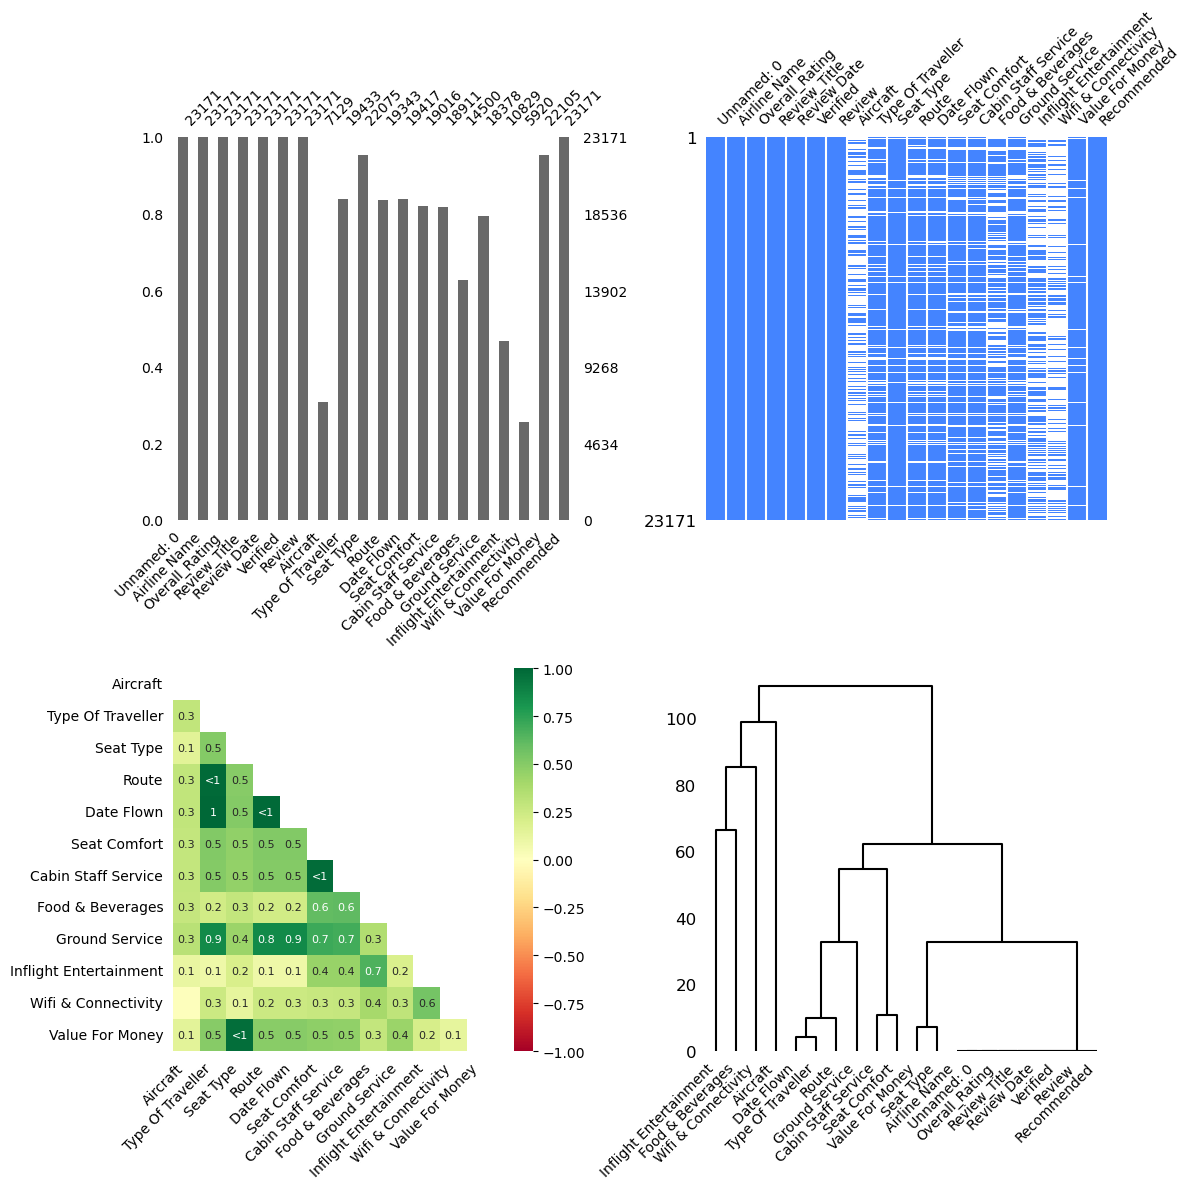

In [4]:
#Диаграмма, матрица, тепловая карта и дендограмма пропущенных значений на исходном наборе данных
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(2,2,1)
msno.bar(airline,fontsize=10,figsize=(6,6),ax=ax1)
ax2 = fig.add_subplot(2,2,2)
msno.matrix(airline,fontsize=10,figsize=(6,6),color=(0.27, 0.52, 1.0),ax=ax2)
ax3 = fig.add_subplot(2,2,3)
msno.heatmap(airline,fontsize=10,figsize=(6,6),cmap="RdYlGn",ax=ax3)
ax4 = fig.add_subplot(2,2,4)
msno.dendrogram(airline,fontsize=10,figsize=(6,6),orientation="top",ax=ax4)

plt.tight_layout()

In [5]:
# Удаление ненужных столбцов
columns_to_drop = ['Airline Name', 'Review_Title', 'Review Date' ,'Verified', 'Aircraft', 'Route', 'Date Flown']
data = airline.drop(columns=columns_to_drop)
data.head(5)

,Unnamed: 0,Overall_Rating,Review,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,9,Moroni to Moheli. Turned out to be a pretty ...,Solo Leisure,Economy Class,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,1,Moroni to Anjouan. It is a very small airline...,Solo Leisure,Economy Class,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,1,Anjouan to Dzaoudzi. A very small airline an...,Solo Leisure,Economy Class,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,1,Please do a favor yourself and do not fly wi...,Solo Leisure,Economy Class,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,1,Do not book a flight with this airline! My fr...,Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


In [6]:
data.describe(include=[object])

,Overall_Rating,Review,Type Of Traveller,Seat Type,Recommended
count,23171,23171,19433,22075,23171
unique,10,23046,4,4,2
top,1,I spend at least the half of my time during a ...,Solo Leisure,Economy Class,no
freq,11595,2,7120,19145,15364


In [7]:
data.describe(include=[float])

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money
count,19016.000000,18911.000000,14500.000000,18378.000000,10829.000000,5920.000000,22105.000000
mean,2.618374,2.871609,2.553586,2.353738,2.179056,1.780405,2.451165
std,1.464840,1.604631,1.526314,1.595747,1.488839,1.318800,1.594155
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,2.000000,1.000000,2.000000,1.000000,2.000000
75%,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [8]:
data['Overall_Rating'].unique()

array(['9', '1', '8', '2', '3', '5', '6', '7', '4', 'n'], dtype=object)

In [9]:
data['Overall_Rating']=data['Overall_Rating'].replace('n',10).astype(int)

In [10]:
data['Overall_Rating'].value_counts(normalize=True)

Overall_Rating
1     0.500410
2     0.099089
9     0.076302
8     0.075828
3     0.058521
7     0.051487
4     0.037072
10    0.036339
5     0.035821
6     0.029131
Name: proportion, dtype: float64

In [11]:
df = pd.DataFrame(data)

# Определяем целевое количество экземпляров для каждого класса
target_count = df['Overall_Rating'].value_counts().max()

# Создаем новый DataFrame для сбалансированных данных
balanced_df = pd.DataFrame()

# Увеличиваем количество экземпляров для каждого класса
for rating in df['Overall_Rating'].unique():
    rating_data = df[df['Overall_Rating'] == rating]
    if len(rating_data) < target_count:
        # Увеличиваем класс до целевого количества
        rating_data = rating_data.sample(target_count, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, rating_data], ignore_index=True)

# Проверяем сбалансированные данные
print(balanced_df['Overall_Rating'].value_counts(normalize=True))
data = pd.DataFrame(balanced_df)

Overall_Rating
9     0.1
1     0.1
8     0.1
2     0.1
3     0.1
5     0.1
6     0.1
7     0.1
4     0.1
10    0.1
Name: proportion, dtype: float64


In [12]:
methods = {
    'Type Of Traveller': 'mode',
    'Seat Type': 'mode',
    'Seat Comfort': 'median',
    'Cabin Staff Service': 'mode',
    'Food & Beverages': 'mode',
    'Ground Service': 'mode',
    'Inflight Entertainment': 'mode',
    'Wifi & Connectivity': 'mode',
    'Value For Money': 'mode'
}

def fill_na(column):
    method = methods.get(column.name)
    if method == 'mean':
        return column.fillna(column.mean())
    elif method == 'mode':
        return column.fillna(column.mode()[0])
    elif method == 'median':
        return column.fillna(column.median())
    return column

data = data.apply(fill_na)
data.head(5)

,Unnamed: 0,Overall_Rating,Review,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,14878,9,Just flew from Vienna to Podgorica and on to B...,Solo Leisure,Economy Class,3.0,4.0,3.0,1.0,1.0,1.0,4.0,yes
1,18256,9,This airline is worth the money every time w...,Couple Leisure,Business Class,4.0,4.0,4.0,4.0,4.0,1.0,4.0,yes
2,10881,9,Just wanted to recognize our HA agent at gat...,Business,Economy Class,5.0,5.0,3.0,5.0,1.0,1.0,5.0,yes
3,16572,9,Amazing service! We booked our return ticket...,Couple Leisure,Economy Class,4.0,4.0,4.0,5.0,4.0,2.0,4.0,yes
4,14904,9,SIN-RGN-SIN. With the JetStar codeshare I actu...,Solo Leisure,Economy Class,3.0,4.0,3.0,1.0,1.0,1.0,4.0,yes


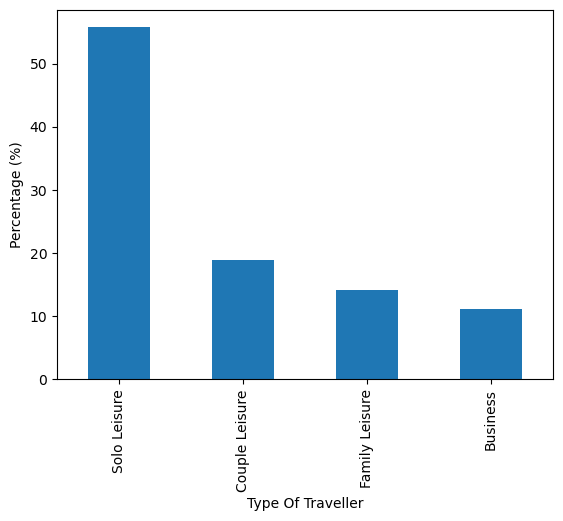

In [13]:
ax = data['Type Of Traveller'].value_counts(normalize=True).mul(100).plot(kind='bar')
ax.set_ylabel('Percentage (%)')
plt.show()

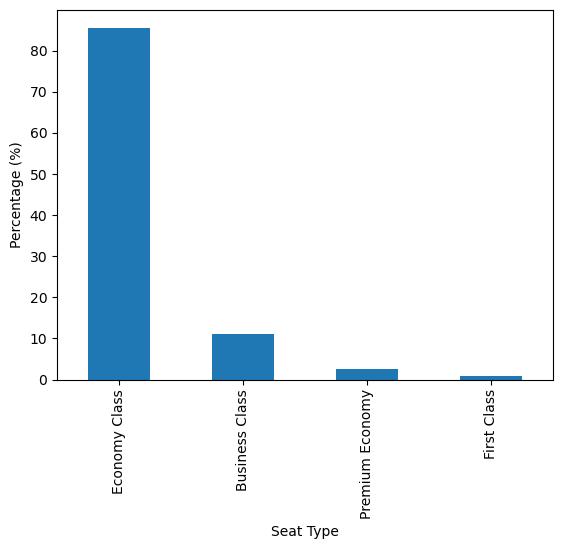

In [14]:
ax = data['Seat Type'].value_counts(normalize=True).mul(100).plot(kind='bar')
ax.set_ylabel('Percentage (%)')
plt.show()

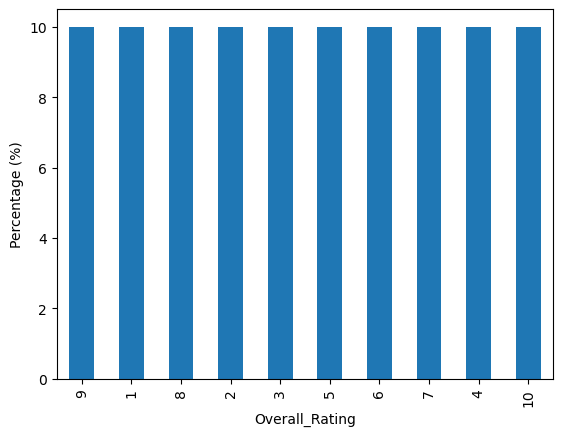

In [15]:
ax = data['Overall_Rating'].value_counts(normalize=True).mul(100).plot(kind='bar')
ax.set_ylabel('Percentage (%)')
plt.show()

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Создание целевых классов на основе рейтинга
def create_class(rating):
    if 1 <= rating <= 2:
        return 'Критик'
    elif 3 <= rating <= 4:
        return 'Недоволен'
    elif 5 <= rating <= 6:
        return 'Нейтрален'
    elif 7 <= rating <= 8:
        return 'Доволен'
    elif 9 <= rating <= 10:
        return 'Промоутер'
    else:
        return None

data['class'] = data['Overall_Rating'].apply(create_class)

# Удаление строк с пропущенными значениями
data = data.dropna(subset=['class'])

# Разделение на признаки (текст отзыва) и целевую переменную
X = data['Review']  # Замените на имя столбца с текстом отзыва
y = data['class']

# Преобразование текста в числовые признаки с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_vectorized = vectorizer.fit_transform(X)

# Кодирование целевых меток
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression(max_iter=1000, multi_class='multinomial')
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.8134109529969814

Classification Report:
              precision    recall  f1-score   support

     Доволен       0.81      0.83      0.82      4638
      Критик       0.79      0.72      0.76      4638
   Недоволен       0.81      0.81      0.81      4638
   Нейтрален       0.84      0.89      0.86      4638
   Промоутер       0.82      0.82      0.82      4638

    accuracy                           0.81     23190
   macro avg       0.81      0.81      0.81     23190
weighted avg       0.81      0.81      0.81     23190



In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.9865459249676585

Classification Report:
              precision    recall  f1-score   support

     Доволен       0.95      1.00      0.97      4638
      Критик       1.00      0.94      0.97      4638
   Недоволен       1.00      1.00      1.00      4638
   Нейтрален       1.00      1.00      1.00      4638
   Промоутер       0.99      1.00      0.99      4638

    accuracy                           0.99     23190
   macro avg       0.99      0.99      0.99     23190
weighted avg       0.99      0.99      0.99     23190



In [19]:
from xgboost import XGBClassifier

model = XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.8836136265631738

Classification Report:
              precision    recall  f1-score   support

     Доволен       0.85      0.92      0.89      4638
      Критик       0.86      0.81      0.83      4638
   Недоволен       0.88      0.90      0.89      4638
   Нейтрален       0.94      0.92      0.93      4638
   Промоутер       0.89      0.87      0.88      4638

    accuracy                           0.88     23190
   macro avg       0.88      0.88      0.88     23190
weighted avg       0.88      0.88      0.88     23190



In [20]:
from sklearn.model_selection import GridSearchCV

# Подбор параметров для логистической регрессии
parameters = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, multi_class='multinomial'),
                         parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.9533850797757654

Classification Report:
              precision    recall  f1-score   support

     Доволен       0.95      0.98      0.97      4638
      Критик       0.97      0.81      0.88      4638
   Недоволен       0.93      0.99      0.96      4638
   Нейтрален       0.97      1.00      0.98      4638
   Промоутер       0.95      0.99      0.97      4638

    accuracy                           0.95     23190
   macro avg       0.95      0.95      0.95     23190
weighted avg       0.95      0.95      0.95     23190



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


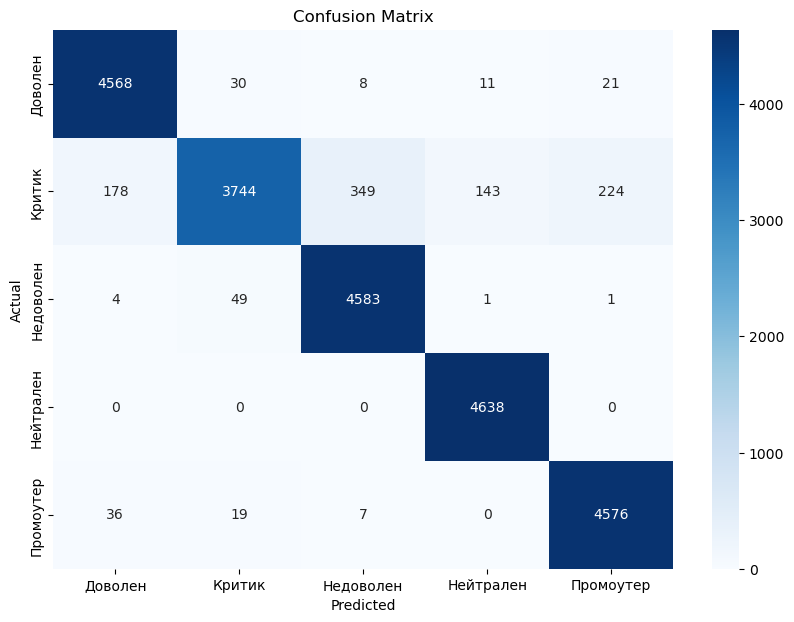

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
def predict_sentiment(text):
    # Преобразование текста
    text_vectorized = vectorizer.transform([text])
    # Предсказание класса
    prediction = model.predict(text_vectorized)
    # Возвращение названия класса
    return label_encoder.inverse_transform(prediction)[0]

# Пример использования
new_review = "Авиакомпания отличная, сервис на высоте!"
print(predict_sentiment(new_review))  # Вероятно, вернет "Промоутер"

Недоволен


In [23]:
new_review = "Не доволен"
print(predict_sentiment(new_review))

Недоволен


In [24]:
new_review = "Кресла не удобные"
print(predict_sentiment(new_review))

Недоволен


In [25]:
new_review = "Еда вкусная"
print(predict_sentiment(new_review))

Недоволен
